<a href="https://colab.research.google.com/github/dimou-gk/Deep-dive-ML/blob/main/SVM_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [2]:
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset & Analysis

In [4]:
df = pd.read_csv('/content/drive/MyDrive/MSc Data and Web Science/Machine Learning/Exercise 7/train.csv')
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
# x = df.drop(columns='target').to_numpy()
# y = df['target'].to_numpy()

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0, stratify=y)
# x_train.shape, x_test.shape, y_train.shape, y_test.shape

train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['target'], random_state=0)
train_df.shape, test_df.shape

((6851, 5), (762, 5))

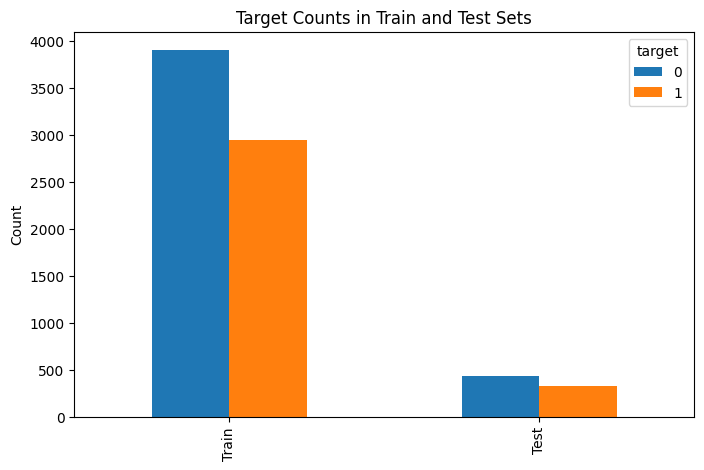

In [6]:
train_counts = train_df['target'].value_counts()
test_counts = test_df['target'].value_counts()

counts_df = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).transpose()
counts_df.plot(kind='bar', figsize=(8, 5))
plt.ylabel('Count')
plt.title('Target Counts in Train and Test Sets')
plt.show()

From the barplot we can safely assume that the examples on the two classes on the two datasets are somewhat distributed equally

# 2-5 Preprocessing

In [7]:
train_df.drop(columns=['id', 'location'], inplace=True)
test_df.drop(columns=['id', 'location'], inplace=True)

train_df.fillna(value='null')
test_df.fillna(value='null')

train_df['inputs'] = train_df['keyword'] + ' ' + train_df['text']
test_df['inputs'] = test_df['keyword'] + ' ' + test_df['text']

In [8]:
import re
from functools import partial
from collections import Counter
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer


def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

with open('/content/drive/MyDrive/MSc Data and Web Science/Machine Learning/Exercise 7/slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())

slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])


train_df['inputs'].apply(lambda x: replaceSlang(replaceAtUser(replaceURL(str(x)))) if pd.notnull(x) else x)
test_df['inputs'].apply(lambda x: replaceSlang(replaceAtUser(replaceURL(str(x)))) if pd.notnull(x) else x)

,inputs
604,bioterror FedEx no longer to transport bioterr...
5374,panic Panic over: Patient in Alabama tests neg...
3022,dust%20storm New Mad Max Screenshots Show Off ...
3357,evacuated Rocky fire in Northern California sw...
4726,lava atUser Lava Blast &amp; Power Red atUser ...
...,...
5098,nuclear%20disaster refugees of nuclear disaste...
525,avalanche Musician Kalle Mattson Recreates 34 ...
5169,obliterate atUser good sir I did not wish to b...
3592,fatal Man charged over fatal crash near Dubbo ...


In [9]:
train_df.head()

,keyword,text,target,inputs
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,1,threat Meek Mill responds to DrakeÛªs OVO Fes...
3940,flood,survived the plague\nfloated the flood\njust p...,0,flood survived the plague\nfloated the flood\n...
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,0,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...
2234,deluge,Vince McMahon once again a billionaire: I reme...,0,deluge Vince McMahon once again a billionaire:...
4233,hazardous,Is it possible to sneak into a hospital so I c...,0,hazardous Is it possible to sneak into a hospi...


In [10]:
X_train = train_df.drop(columns=['target']).values
y_train = train_df['target'].values

X_test = test_df.drop(columns=['target']).values
y_test = test_df['target'].values

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer()

X_train_tfid = tfid.fit_transform(X_train[:,2].astype('U'))
X_test_tfid = tfid.transform(X_test[:,2].astype('U'))

# 6. Training & Testing

In [12]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train_tfid, y_train)

y_pred_train = model.predict(X_train_tfid)
y_pred = model.predict(X_test_tfid)

#--------------------------------------------------------
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred)

precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred)

recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred)

print(f'Accuracy for train set is: {accuracy_train}')
print(f'Accuracy for test set is: {accuracy_test}')
print(f'F1 Score for train set is: {f1_train}')
print(f'F1 Score for test set is: {f1_test}')
print(f'Precision for train set is: {precision_train}')
print(f'Precision for test set is: {precision_test}')
print(f'Recall for train set is: {recall_train}')
print(f'Recall for test set is: {recall_test}')

Accuracy for train set is: 0.9773755656108597
Accuracy for test set is: 0.7979002624671916
F1 Score for train set is: 0.9733905579399141
F1 Score for test set is: 0.7586206896551724
Precision for train set is: 0.9840333217632766
Precision for test set is: 0.7781350482315113
Recall for train set is: 0.9629755434782609
Recall for test set is: 0.7400611620795107


Based on our problem we need to give special attention to examples falsely categorized as non-catastrophes when are in fact catastrophes, in other words False Negatives. Recall metric serves this purpose thus it is more important than the others.

# 7. PCA

In [17]:
from sklearn.decomposition import PCA

X_train_dense = X_train_tfid.toarray()
X_test_dense = X_test_tfid.toarray()

pca = PCA(n_components=0.95, svd_solver='full')

pca_train = pca.fit_transform(X_train_dense)
pca_test = pca.transform(X_test_dense)

In [18]:
from sklearn.svm import SVC, LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(pca_train, y_train)
linear_svc_predictions = linear_svc.predict(pca_test)

rbf_svc = SVC(kernel='rbf')
rbf_svc.fit(pca_train, y_train)
rbf_svc_predictions = rbf_svc.predict(pca_test)

In [19]:
print("LinearSVC Performance:")
print(classification_report(y_test, linear_svc_predictions))

print("SVC with RBF Kernel Performance:")
print(classification_report(y_test, rbf_svc_predictions))

LinearSVC Performance:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       435
           1       0.78      0.75      0.76       327

    accuracy                           0.80       762
   macro avg       0.80      0.79      0.80       762
weighted avg       0.80      0.80      0.80       762

SVC with RBF Kernel Performance:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       435
           1       0.78      0.76      0.77       327

    accuracy                           0.81       762
   macro avg       0.80      0.80      0.80       762
weighted avg       0.81      0.81      0.81       762



# 8. Gamma

In the context of SVM gamma parameter controls the level of influence a single training point has on the decision boundary.

If gamma is:


*   'scale' then it uses 1 / (n_features * X.var()) as value of gamma [[1]](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
*   'auto', uses 1 / n_features



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


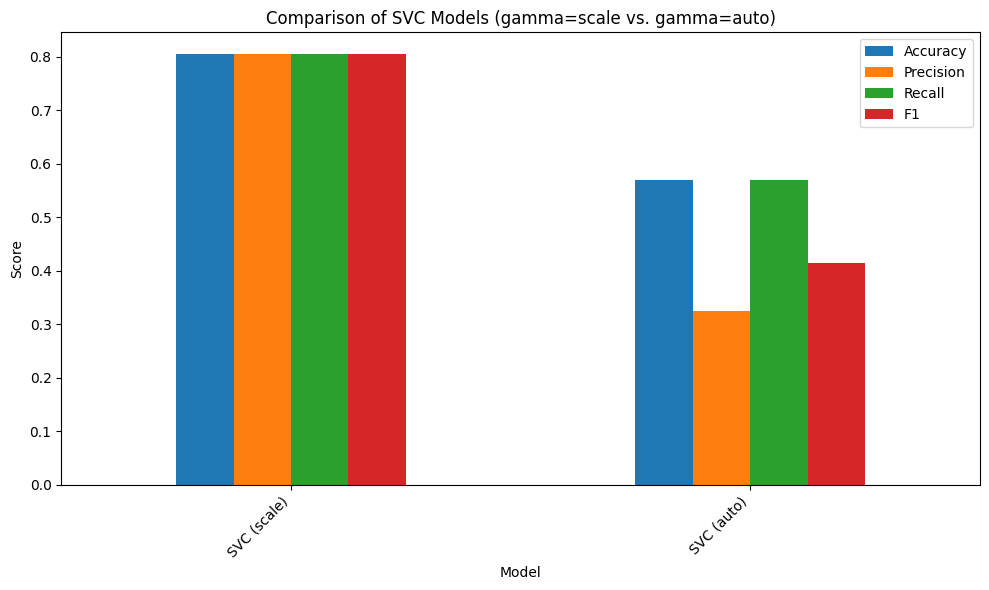

In [20]:
rbf_svc_auto = SVC(kernel='rbf', gamma='auto', random_state=0)

rbf_svc_auto.fit(pca_train, y_train)
rbf_svc_auto_predictions = rbf_svc_auto.predict(pca_test)

metrics = {
    "Model": ["SVC (scale)", "SVC (auto)"],
    "Accuracy": [
        accuracy_score(y_test, rbf_svc_predictions),
        accuracy_score(y_test, rbf_svc_auto_predictions)
    ],
    "Precision": [
        precision_score(y_test, rbf_svc_predictions, average='weighted'),
        precision_score(y_test, rbf_svc_auto_predictions, average='weighted')
    ],
    "Recall": [
        recall_score(y_test, rbf_svc_predictions, average='weighted'),
        recall_score(y_test, rbf_svc_auto_predictions, average='weighted')
    ],
    "F1": [
        f1_score(y_test, rbf_svc_predictions, average='weighted'),
        f1_score(y_test, rbf_svc_auto_predictions, average='weighted')
    ]
}

metrics_df = pd.DataFrame(metrics)

metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6))
plt.title("Comparison of SVC Models (gamma=scale vs. gamma=auto)")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Naive Bayes

In [22]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train_dense, y_train)

y_pred_train = model.predict(X_train_dense)
y_pred = model.predict(X_test_dense)

#--------------------------------------------------------
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred)

precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred)

recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred)

print(f'Accuracy for train set is: {accuracy_train}')
print(f'Accuracy for test set is: {accuracy_test}')
print(f'F1 Score for train set is: {f1_train}')
print(f'F1 Score for test set is: {f1_test}')
print(f'Precision for train set is: {precision_train}')
print(f'Precision for test set is: {precision_test}')
print(f'Recall for train set is: {recall_train}')
print(f'Recall for test set is: {recall_test}')

Accuracy for train set is: 0.9538753466647205
Accuracy for test set is: 0.6299212598425197
F1 Score for train set is: 0.9490651192778853
F1 Score for test set is: 0.6475
Precision for train set is: 0.9030674846625767
Precision for test set is: 0.547568710359408
Recall for train set is: 1.0
Recall for test set is: 0.7920489296636085
